In [6]:
#!pip uninstall -y tensorflow tensorflow-intel tensorflow-gpu

In [7]:
#!pip uninstall -y tensorflow-io-gcs-filesystem 0.31.0
#!pip uninstall -y tensorflow-estimator         2.13.0

In [8]:
#!pip cache purge

In [9]:
#!pip install --upgrade pip

In [10]:
#!pip install tensorflow==2.15.0 --upgrade

In [11]:
#!pip list | findstr tensorflow

In [12]:
'''
import tensorflow as tf

# Verificar dispositivos disponibles
print("Dispositivos disponibles:")
print(tf.config.list_physical_devices())
'''

'\nimport tensorflow as tf\n\n# Verificar dispositivos disponibles\nprint("Dispositivos disponibles:")\nprint(tf.config.list_physical_devices())\n'

In [13]:
'''
# 📚 IMPORTAR LIBRERÍAS PRINCIPALES
import tensorflow as tf
import os

# ⚙️ CONFIGURAR USO DE GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar solo la primera GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU configurada correctamente.")
    except RuntimeError as e:
        print(e)
else:
    print("❌ No se encontró GPU. Usando CPU.")
'''

'\n# 📚 IMPORTAR LIBRERÍAS PRINCIPALES\nimport tensorflow as tf\nimport os\n\n# ⚙️ CONFIGURAR USO DE GPU\ngpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n    try:\n        # Configurar solo la primera GPU\n        tf.config.experimental.set_memory_growth(gpus[0], True)\n        tf.config.set_visible_devices(gpus[0], \'GPU\')\n        print("✅ GPU configurada correctamente.")\n    except RuntimeError as e:\n        print(e)\nelse:\n    print("❌ No se encontró GPU. Usando CPU.")\n'

In [14]:
# ✅ Forzar el uso de CPU en TensorFlow
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Desactiva las GPUs explícitamente

# ✅ Verificar dispositivos disponibles
print("Dispositivos disponibles:")
print(tf.config.list_physical_devices())

Dispositivos disponibles:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [15]:
# 📚 Librerías Necesarias
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib

# ✅ Parámetros Globales optimizados para CPU
IMG_SIZE = (128, 128)  # Tamaño de las imágenes
BATCH_SIZE = 16        # Reduce el tamaño del batch para evitar sobrecarga
EPOCHS = 30            # Menos épocas para iteraciones más rápidas
COLOR_MODE = 'grayscale'  # Imágenes en escala de grises
AUTOTUNE = tf.data.AUTOTUNE

In [16]:
# ✅ Rutas de Datos
ruta_train_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train.csv'
ruta_test_csv = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_train_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'D:\Archivos de usuarios\Mikel Telo\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# ✅ Cargar Datos
df_train = pd.read_csv(ruta_train_csv)
df_test = pd.read_csv(ruta_test_csv)

# ✅ Preprocesamiento de Imágenes optimizado para CPU
def cargar_datos(df, ruta_img, es_entrenamiento=True):
    ids = df['id'].values
    labels = df['clip_count'].values if 'clip_count' in df.columns else None
    
    def preprocesar_imagen(id, label=None):
        img_path = tf.strings.join([ruta_img, "/clips-", tf.strings.as_string(id), ".png"])
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return (img, tf.cast(label, tf.float32)) if label is not None else img
    
    if es_entrenamiento:
        dataset = tf.data.Dataset.from_tensor_slices((ids, labels))
        dataset = dataset.map(
            lambda id, label: preprocesar_imagen(id, label),
            num_parallel_calls=tf.data.AUTOTUNE  # Optimiza la paralelización
        )
        dataset = dataset.cache()  # Guarda en caché para evitar recargar imágenes
        dataset = dataset.shuffle(buffer_size=1000)  # Ajusta según la memoria disponible
    else:
        dataset = tf.data.Dataset.from_tensor_slices(ids)
        dataset = dataset.map(
            lambda id: preprocesar_imagen(id),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# ✅ Crear Datasets
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
dataset_train = cargar_datos(df_train, ruta_train_img, es_entrenamiento=True)
dataset_val = cargar_datos(df_val, ruta_train_img, es_entrenamiento=True)
dataset_test = cargar_datos(df_test, ruta_test_img, es_entrenamiento=False)

In [17]:
# ✅ Definir el Modelo CNN
def crear_modelo():
    modelo = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')  # Salida de regresión
    ])
    
    modelo.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return modelo

# ✅ Crear Modelo
modelo = crear_modelo()
modelo.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                      

Epoch 1/30

750/750 [==============================] - 156s 205ms/step - loss: 124.1991 - rmse: 11.1445 - val_loss: 109.0508 - val_rmse: 10.4427 - lr: 0.0010
Epoch 2/30
750/750 [==============================] - 140s 187ms/step - loss: 85.2662 - rmse: 9.2340 - val_loss: 60.1087 - val_rmse: 7.7530 - lr: 0.0010
Epoch 3/30
750/750 [==============================] - 132s 176ms/step - loss: 75.1998 - rmse: 8.6718 - val_loss: 29.6739 - val_rmse: 5.4474 - lr: 0.0010
Epoch 4/30
750/750 [==============================] - 145s 193ms/step - loss: 67.8790 - rmse: 8.2389 - val_loss: 146.7863 - val_rmse: 12.1155 - lr: 0.0010
Epoch 5/30
750/750 [==============================] - 130s 173ms/step - loss: 69.3998 - rmse: 8.3307 - val_loss: 208.7249 - val_rmse: 14.4473 - lr: 0.0010
Epoch 6/30
750/750 [==============================] - 141s 188ms/step - loss: 68.0365 - rmse: 8.2484 - val_loss: 64.9065 - val_rmse: 8.0565 - lr: 0.0010
Epoch 7/30
750/750 [==============================] - 134s 179ms/step - l

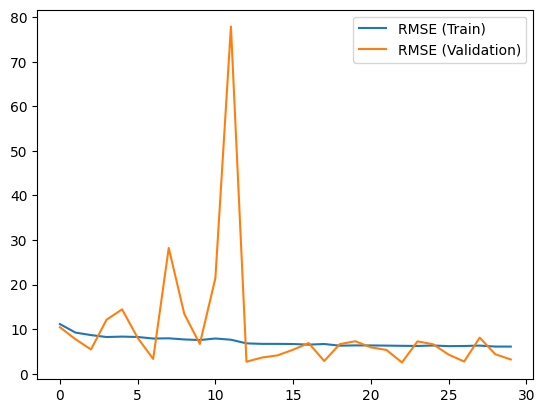

In [18]:
# ✅ Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

# ✅ Entrenar Modelo
historial = modelo.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

# ✅ Graficar Métricas
plt.plot(historial.history['rmse'], label='RMSE (Train)')
plt.plot(historial.history['val_rmse'], label='RMSE (Validation)')
plt.legend()
plt.show()

In [19]:
# ✅ Evaluación
train_loss, train_rmse = modelo.evaluate(dataset_train)
val_loss, val_rmse = modelo.evaluate(dataset_val)
print(f"🔹 RMSE (Train): {train_rmse:.2f}")
print(f"🔹 RMSE (Validation): {val_rmse:.2f}")

# ✅ Predicciones
predicciones = modelo.predict(dataset_test).flatten()
df_test['clip_count'] = np.round(predicciones).astype(int)

# ✅ Guardar Resultados
df_test[['id', 'clip_count']].to_csv('submission.csv', index=False)
print("✅ Archivo 'submission.csv' generado correctamente.")

188/188 [==============================] - 8s 40ms/step - loss: 10.2427 - rmse: 3.2004
🔹 RMSE (Train): 2.93
🔹 RMSE (Validation): 3.20
313/313 [==============================] - 30s 92ms/step
✅ Archivo 'submission.csv' generado correctamente.


In [20]:
# Guardar el modelo final
modelo.save('modelo_final/modelo_clip_count.h5')
print("✅ Modelo guardado como 'modelo_clip_count.h5'")

c:\Users\mikel\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ Modelo guardado como 'modelo_clip_count.h5'


In [22]:
df_test.describe()

,id,clip_count
count,5000.000000,5000.00000
mean,47500.500000,35.32500
std,1443.520003,20.53037
min,45001.000000,1.00000
25%,46250.750000,17.00000
50%,47500.500000,35.00000
75%,48750.250000,53.00000
max,50000.000000,74.00000


In [23]:
df_train.describe()

,id,clip_count
count,12000.000000,12000.000000
mean,37514.099917,37.310333
std,4328.652185,21.913635
min,30001.000000,0.000000
25%,33771.750000,18.000000
50%,37510.500000,37.000000
75%,41245.500000,56.000000
max,45000.000000,75.000000
